In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy.stats import percentileofscore

In [2]:
def get_arome_data(url):

#url = 'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&run=9&mode=8&sort=0'  # Replace this with the URL containing the table

    url = url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])

    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date",axis=1)
    df = df.drop("Ech.",axis=1)
    df = df.astype("float")

    return df

def get_last_arome_run():

    runs = [3, 9, 15, 21]
    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=43.35&lon=-4.047&mode=8&sort=0'

    first_index = pd.Timestamp(year=2017, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        first_index_run = get_arome_data(url_run).index[0]

        if first_index_run > first_index:
            first_index = first_index_run
            valid_run = run
        else:
            pass

    return valid_run


valid_run = get_last_arome_run()

In [3]:
valid_run

9

In [4]:

def get_arome_data(url):

#url = 'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&run=9&mode=8&sort=0'  # Replace this with the URL containing the table

    url = url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])

    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date",axis=1)
    df = df.drop("Ech.",axis=1)
    df = df.astype("float")

    return df


def get_last_arome_run():

    runs = [3, 9, 15, 21]
    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&mode=8&sort=0'

    last_index = pd.Timestamp(year=2017, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        last_index_run = get_arome_data(url_run).index[-1]

        if last_index_run > last_index:
            last_index = last_index_run
            valid_run = run
        else:
            pass

    return valid_run


valid_run = get_last_arome_run()




aemet_horario = pd.read_csv("https://www.aemet.es/es/eltiempo/observacion/ultimosdatos_3195_datos-horarios.csv?k=mad&l=3195&datos=det&w=0&f=temperatura&x=h24" ,
                            encoding="latin-1",skiprows=2,parse_dates=True,index_col=0,dayfirst=True)
aemet_horario.index = aemet_horario.index.tz_localize('Europe/Madrid')



aemet_horario_acumulado = pd.read_excel("Histórico/Acumulado.xlsx",index_col=0)
aemet_horario_acumulado.index = aemet_horario_acumulado.index.tz_localize('Europe/Madrid')

aemet_horario_acumulado = pd.concat([aemet_horario_acumulado,aemet_horario])

aemet_horario_acumulado = aemet_horario_acumulado[~aemet_horario_acumulado.index.duplicated(keep='first')]

aemet_horario_acumulado = aemet_horario_acumulado.sort_index(ascending=False)

aemet_horario_acumulado.index = aemet_horario_acumulado.index.tz_localize(None)

aemet_horario_acumulado.to_excel("Histórico/Acumulado.xlsx")

In [5]:
def get_temp_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=8&sort=0'
    url_run = f'{url}&run={valid_run}'

    temp_data = get_arome_data(url_run)

    print(url_run)

    return temp_data

In [6]:
temp_data = get_temp_data(valid_run)
temp_data["Actual data"] = aemet_horario["Temperatura (ºC)"]

https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=8&sort=0&run=9


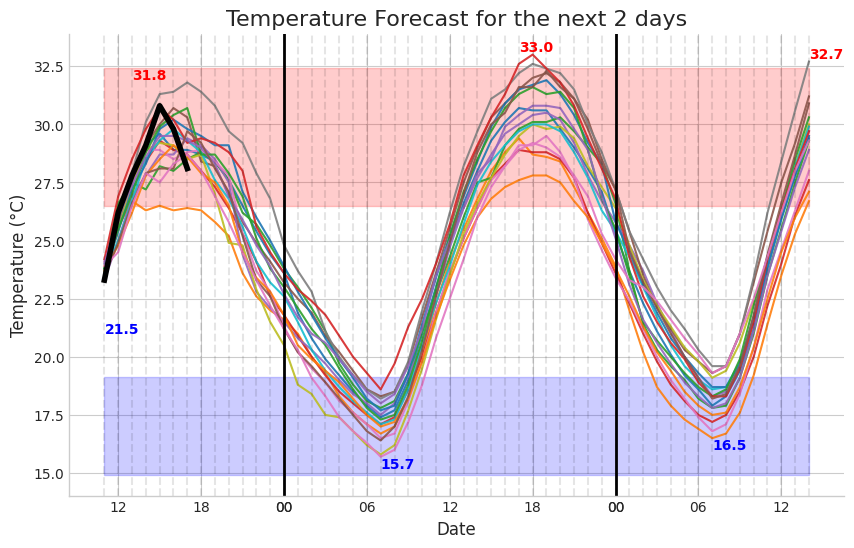

In [8]:

def get_temp_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=8&sort=0'
    url_run = f'{url}&run={valid_run}'

    temp_data = get_arome_data(url_run)

    return temp_data

def get_wind_gust_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=13&sort=0'
    url_run = f'{url}&run={valid_run}'

    wind_gust_data = get_arome_data(url_run)

    return wind_gust_data

def get_pressure_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=1&sort=0'
    url_run = f'{url}&run={valid_run}'

    pressure_data = get_arome_data(url_run)

    return pressure_data

def get_mucape_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=0&sort=0'
    url_run = f'{url}&run={valid_run}'

    mucape_data = get_arome_data(url_run)

    return mucape_data

def get_prec_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=10&sort=0'
    url_run = f'{url}&run={valid_run}'

    prec_data = get_arome_data(url_run)

    return prec_data


#####################################################

datos_df_global = pd.read_csv("retiro 1950.csv",index_col="fecha",parse_dates=True)

datos_df_global = datos_df_global[~((datos_df_global.index.month == 2) & (datos_df_global.index.day == 29) & datos_df_global.index.is_leap_year)]

datos_df_global['día_del_año'] = datos_df_global.index.day_of_year

es_bisiesto = datos_df_global.index.year % 4 == 0
es_bisiesto &= (datos_df_global.index.year % 100 != 0) | (datos_df_global.index.year % 400 == 0)
marzo_en_adelante = datos_df_global.index.month >= 3
datos_df_global.loc[es_bisiesto & marzo_en_adelante, 'día_del_año'] -= 1

temp_medias = datos_df_global[["día_del_año","tmed","tmax","tmin"]]
temp_medias = temp_medias.dropna(how="any")

temp_medias_rolling = temp_medias[["tmed","tmax","tmin"]].rolling(15,center=True).mean().dropna()
temp_medias_rolling["día del año"] = temp_medias_rolling.index.day_of_year

es_bisiesto = temp_medias_rolling.index.year % 4 == 0
es_bisiesto &= (temp_medias_rolling.index.year % 100 != 0) | (temp_medias_rolling.index.year % 400 == 0)
marzo_en_adelante = temp_medias_rolling.index.month >= 3
temp_medias_rolling.loc[es_bisiesto & marzo_en_adelante, 'día del año'] -= 1

temp_medias_rolling = temp_medias_rolling.groupby("día del año").quantile([0.15, 0.85]).unstack()

#####################################################

año_max_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].idxmax().year
año_min_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].idxmax().year

año_min_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].idxmin().year
año_max_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].idxmin().year

max_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].max()
min_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].max()

min_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].min()
max_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].min()

records_dia = pd.DataFrame(columns=["T. max","T. min"],index=["Record calor","Record frío"])
records_dia["T. max"] = ["{} ({})".format(max_maxima, año_max_maxima),"{} ({})".format(max_minima, año_max_minima)]
records_dia["T. min"] = ["{} ({})".format(min_maxima, año_min_maxima),"{} ({})".format(min_minima, año_min_minima)]
records_dia = records_dia.style.apply(lambda x: ['background-color: rgba(255, 204, 204, 0.4)' if x.name == 'T. max' else 'background-color: rgba(204, 204, 255, 0.4)' for i in x], 
                        axis=0, subset=pd.IndexSlice[:, ['T. max', 'T. min']])


#st.write(aemet_horario.index[0].strftime("%A %d %B %H:%M: "),str(aemet_horario["Temperatura (ºC)"].iloc[0])+"º")



temp_data = get_temp_data(valid_run)
temp_data["Actual data"] = aemet_horario["Temperatura (ºC)"]

temp_actual = aemet_horario["Temperatura (ºC)"].iloc[0]
temp_ayer = aemet_horario.iloc[-1]["Temperatura (ºC)"]

dia_mañana = (datetime.now() + timedelta(hours=26)).day
hora = (datetime.now() + timedelta(hours=2)).hour

temp_mañana = temp_data.loc[temp_data.index[(temp_data.index.hour==hora) & (temp_data.index.day ==dia_mañana)]].mean(axis=1)[0].round(1)
desv_temp = temp_data.loc[temp_data.index[(temp_data.index.hour==hora) & (temp_data.index.day ==dia_mañana)]].std(axis=1).round(1)[0]

fiabilidad = 10*np.exp(-0.05*desv_temp**2.5)

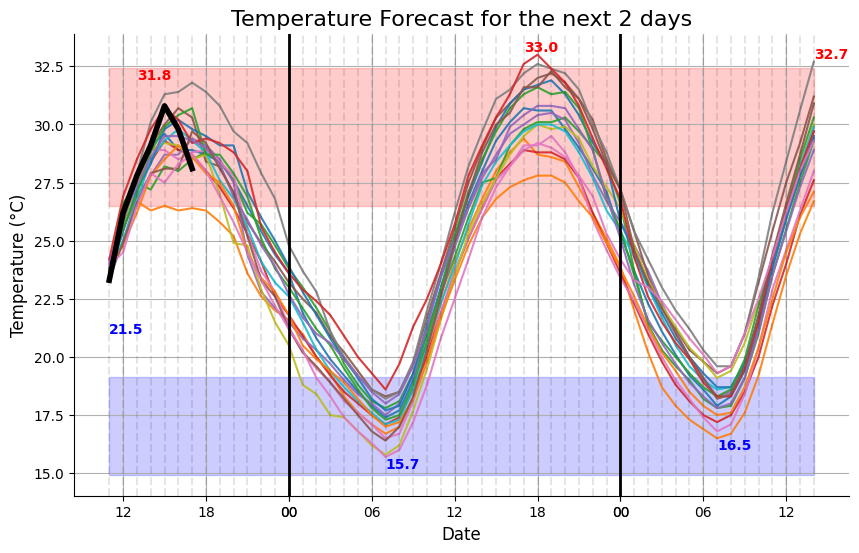

In [41]:
def plot_temp_data(data):
        

        data = data
        # Set figure size and resolution
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

        # Set plot style
        plt.style.use('default')

        # Iterate over the columns and plot each one
        for column in data.columns[:-1]:
            ax.plot(data.index, data[column], alpha=0.9)

        ax.plot(data["Actual data"], alpha=1,linewidth=4,color="black")

        # Add title and labels


        plt.title('Temperature Forecast for the next 2 days', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Temperature (°C)', fontsize=12)



        # Remove top and right spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Set x-axis tick parameters
        plt.xticks(fontsize=10, rotation=0, ha='right')

        # Set y-axis tick parameters
        plt.yticks(fontsize=10)

        # Add vertical lines for each hour
        for hour in data.index:
            ax.axvline(hour, linestyle='--', color='black', alpha=0.1)

        # Remove gridlines
        plt.grid(True)

        # Compute the minimum and maximum temperature for each day and their respective indexes
        dates = list(set(data.index.date))
        min_temps = []
        max_temps = []
        min_idx = []
        max_idx = []

        for date in dates:
            df = data.loc[data.index.date == date]
            min_temp = df.min().min()
            max_temp = df.max().max()
            min_idx.append(data.loc[data.index.date == date].idxmin().min())
            max_idx.append(data.loc[data.index.date == date].idxmax().min())
            min_temps.append(min_temp)
            max_temps.append(max_temp)

        # Add the minimum temperature text to the plot
        for i, temp in enumerate(min_temps):
            min_temp = "{:.1f}".format(temp)
            ax.text(min_idx[i], temp, min_temp, ha='left', va='top', color='blue',fontweight="bold")

        # Add the maximum temperature text to the plot
        for i, temp in enumerate(max_temps):
            max_temp = "{:.1f}".format(temp)
            ax.text(max_idx[i], temp, max_temp, ha='left', va='bottom', color='red',fontweight="bold")


        max_usual_temp_upper = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmax"].iloc[0]
        max_usual_temp_lower = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmax"].iloc[1]

        ax.fill_between(data.index,max_usual_temp_upper,max_usual_temp_lower, alpha=0.2, color='red')

        min_usual_temp_upper = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmin"].iloc[0]
        min_usual_temp_lower = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmin"].iloc[1]

        ax.fill_between(data.index,min_usual_temp_upper,min_usual_temp_lower, alpha=0.2, color='blue')



        # Format x-axis ticks
        # Format x-axis ticks
        ticks = []
        tick_labels = []
        for date in data.index:
                if date.hour == 0:
                    tick_labels.append(date.strftime('%A %d %B'))
                    ticks.append(date)
                    ax.axvline(date,0,1,color="black",linewidth=2)
                if date.hour % 6 == 0:
                    tick_labels.append(date.strftime('%H'))
                    ticks.append(date)
                    pass

        ax.set_xticks(ticks);
        ax.set_xticklabels(tick_labels, fontsize=10, rotation=0, ha='center');

        return 

plot_temp_data(temp_data)

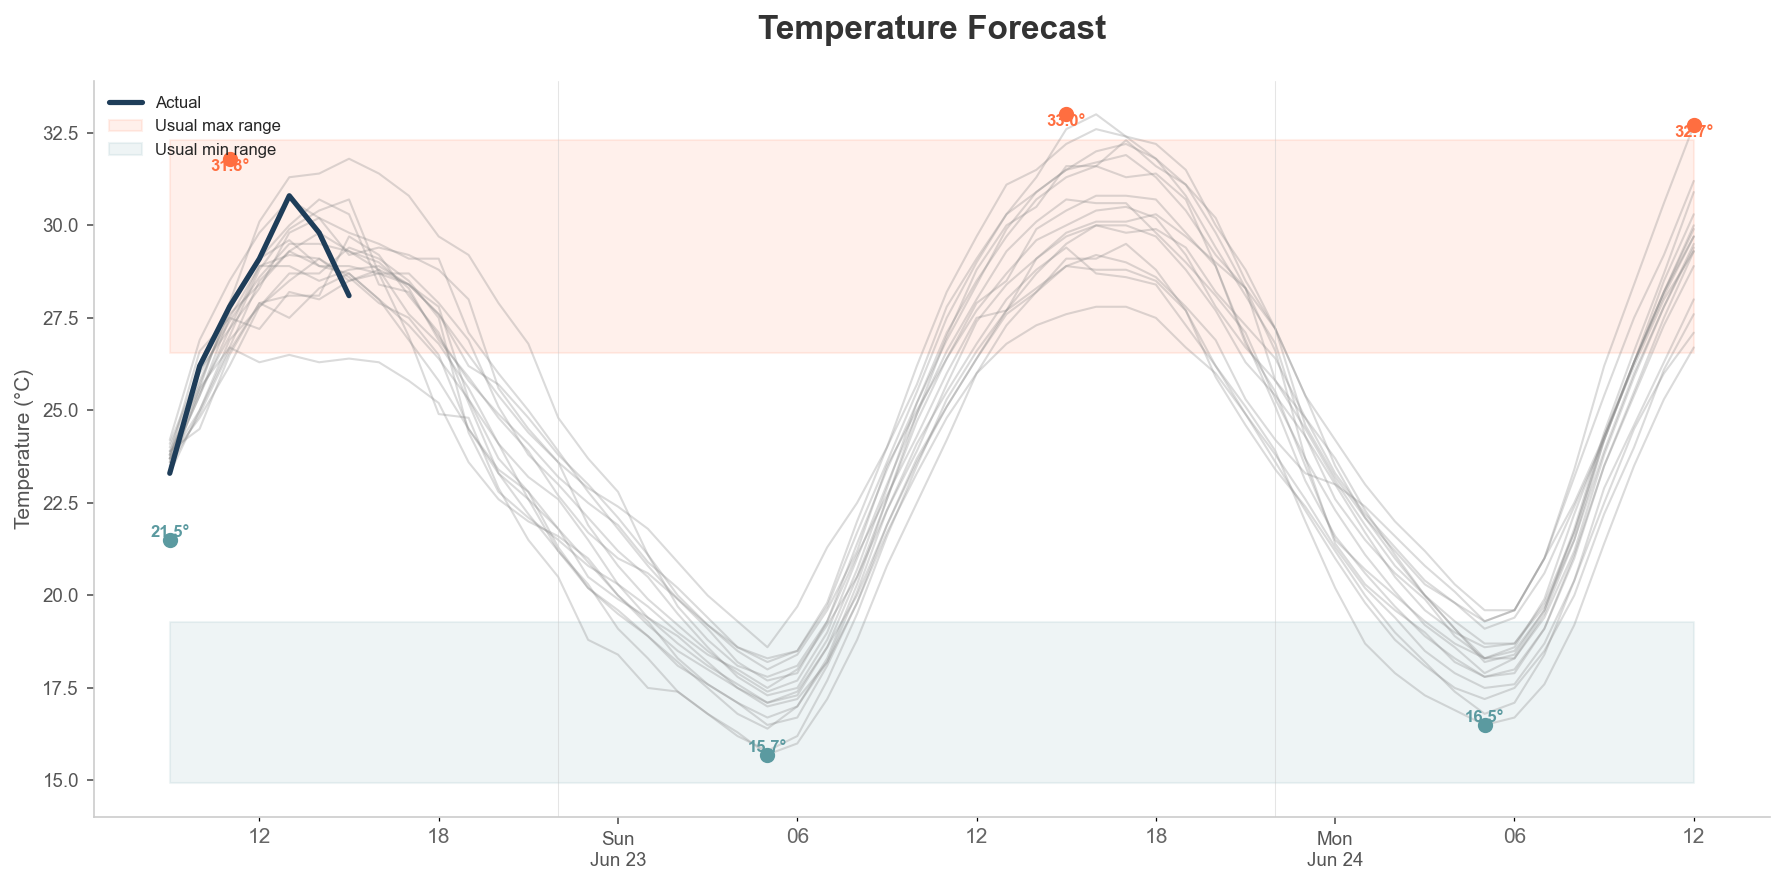

In [42]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def plot_temp_data(data, temp_medias_rolling):
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
    sns.set_style("whitegrid")
    plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']

    # Plot temperature data
    for column in data.columns[:-1]:
        ax.plot(data.index, data[column], alpha=0.3, linewidth=1, color='#888888')
    ax.plot(data.index, data["Actual data"], alpha=1, linewidth=2.5, color="#1e3d59", label="Actual")

    # Plot usual temperature ranges
    day_of_year = data.index[0].dayofyear
    max_usual = temp_medias_rolling.iloc[day_of_year]["tmax"]
    min_usual = temp_medias_rolling.iloc[day_of_year]["tmin"]
    ax.fill_between(data.index, max_usual.iloc[0], max_usual.iloc[1], alpha=0.1, color='#ff6e40', label="Usual max range")
    ax.fill_between(data.index, min_usual.iloc[0], min_usual.iloc[1], alpha=0.1, color='#5b9aa0', label="Usual min range")

    # Styling
    ax.set_xlabel('')
    ax.set_ylabel('Temperature (°C)', fontsize=10, color='#555555')
    ax.tick_params(axis='both', which='major', labelsize=9, colors='#555555')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')

    # X-axis formatting
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%b %d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center', rotation=0)
    plt.setp(ax.xaxis.get_minorticklabels(), ha='center', rotation=0, alpha=0.6)

    # Highlight day changes
    for date in data.index[data.index.hour == 0]:
        ax.axvline(date, color='#cccccc', linestyle='-', linewidth=0.5, alpha=0.5)

    # Add min and max temperatures
    for date in set(data.index.date):
        day_data = data[data.index.date == date]
        min_temp = day_data.min().min()
        max_temp = day_data.max().max()
        min_time = day_data.idxmin().min()
        max_time = day_data.idxmax().min()
        
        ax.scatter(min_time, min_temp, color='#5b9aa0', s=40, zorder=5)
        ax.scatter(max_time, max_temp, color='#ff6e40', s=40, zorder=5)
        ax.text(min_time, min_temp, f'{min_temp:.1f}°', ha='center', va='bottom', fontsize=8, color='#5b9aa0', fontweight='bold')
        ax.text(max_time, max_temp, f'{max_temp:.1f}°', ha='center', va='top', fontsize=8, color='#ff6e40', fontweight='bold')

    # Title and legend
    plt.title('Temperature Forecast', fontsize=16, fontweight='bold', color='#333333', pad=20)
    ax.legend(loc='upper left', frameon=False, fontsize=8)

    # Final adjustments
    plt.tight_layout()
    return fig

# Assuming temp_data and temp_medias_rolling are defined
fig = plot_temp_data(temp_data, temp_medias_rolling)
plt.show()


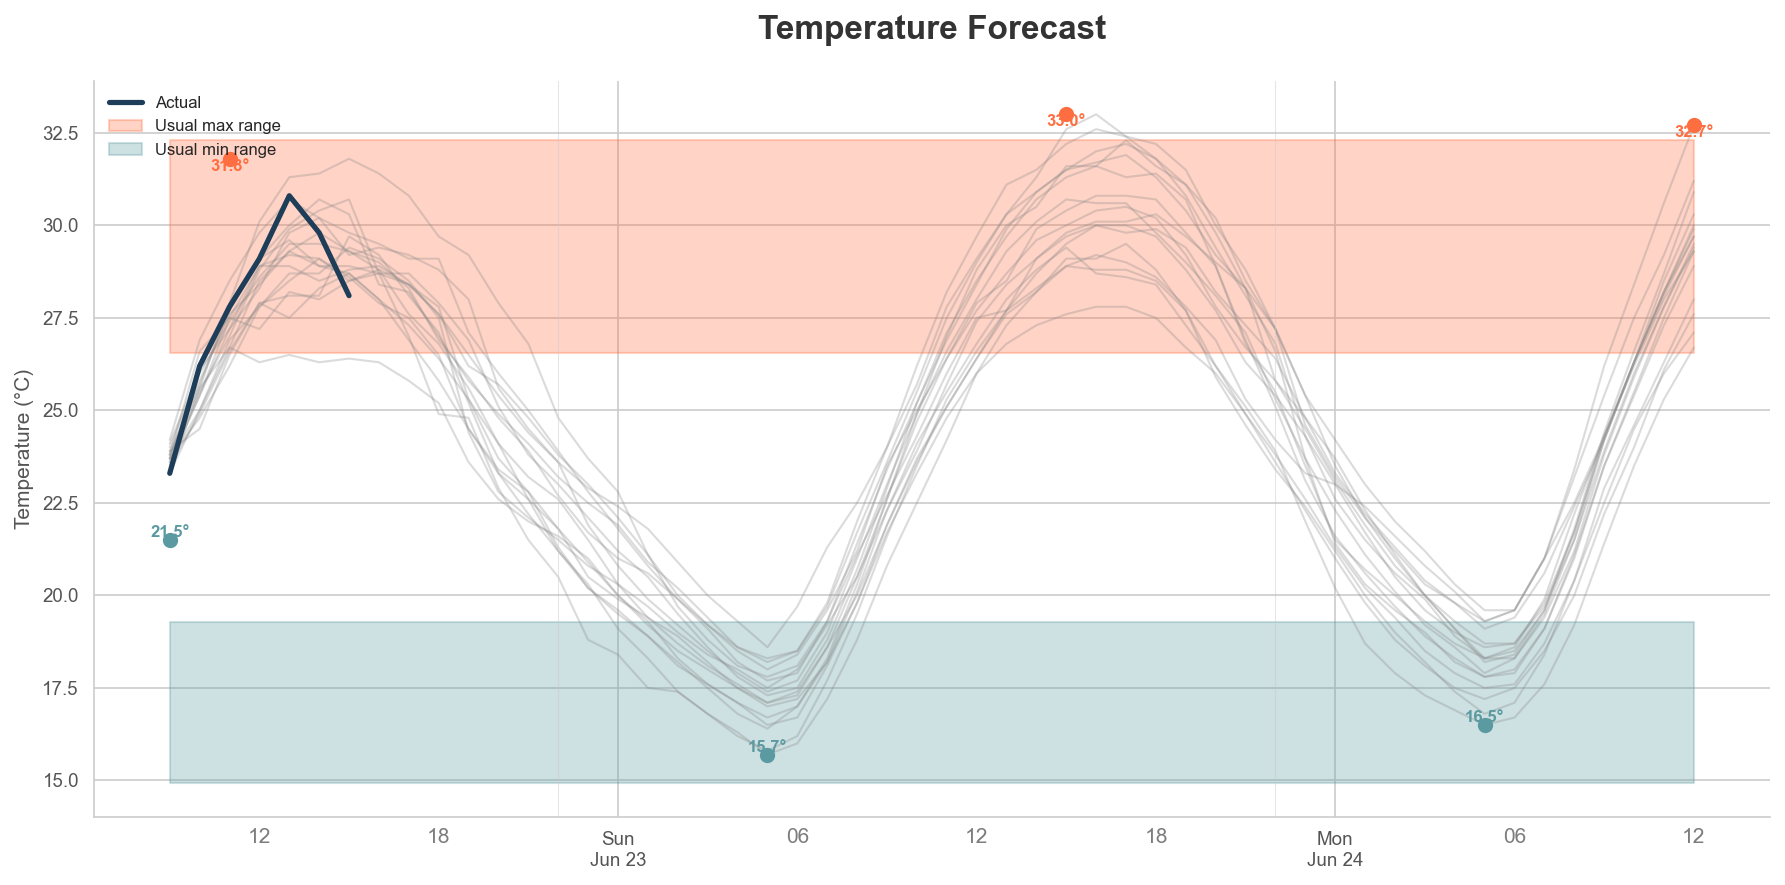

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def plot_temp_data(data, temp_medias_rolling):
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
    sns.set_style("whitegrid")
    plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']

    # Plot temperature data
    for column in data.columns[:-1]:
        ax.plot(data.index, data[column], alpha=0.3, linewidth=1, color='#888888')
    ax.plot(data.index, data["Actual data"], alpha=1, linewidth=2.5, color="#1e3d59", label="Actual")

    # Plot usual temperature ranges with darker colors
    day_of_year = data.index[0].dayofyear
    max_usual = temp_medias_rolling.iloc[day_of_year]["tmax"]
    min_usual = temp_medias_rolling.iloc[day_of_year]["tmin"]
    ax.fill_between(data.index, max_usual.iloc[0], max_usual.iloc[1], alpha=0.3, color='#ff6e40', label="Usual max range")
    ax.fill_between(data.index, min_usual.iloc[0], min_usual.iloc[1], alpha=0.3, color='#5b9aa0', label="Usual min range")

    # Styling
    ax.set_xlabel('')
    ax.set_ylabel('Temperature (°C)', fontsize=10, color='#555555')
    ax.tick_params(axis='both', which='major', labelsize=9, colors='#555555')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')

    # X-axis formatting
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%b %d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center', rotation=0)
    plt.setp(ax.xaxis.get_minorticklabels(), ha='center', rotation=0, alpha=0.6)

    # Highlight day changes
    for date in data.index[data.index.hour == 0]:
        ax.axvline(date, color='#cccccc', linestyle='-', linewidth=0.5, alpha=0.5)

    # Add min and max temperatures at the correct hours
    for date in set(data.index.date):
        day_data = data[data.index.date == date]
        min_temp = day_data.min().min()
        max_temp = day_data.max().max()
        min_time = day_data.idxmin().min()
        max_time = day_data.idxmax().min()
        
        ax.scatter(min_time, min_temp, color='#5b9aa0', s=40, zorder=5)
        ax.scatter(max_time, max_temp, color='#ff6e40', s=40, zorder=5)
        ax.text(min_time, min_temp, f'{min_temp:.1f}°', ha='center', va='bottom', fontsize=8, color='#5b9aa0', fontweight='bold')
        ax.text(max_time, max_temp, f'{max_temp:.1f}°', ha='center', va='top', fontsize=8, color='#ff6e40', fontweight='bold')

    # Title and legend
    plt.title('Temperature Forecast', fontsize=16, fontweight='bold', color='#333333', pad=20)
    ax.legend(loc='upper left', frameon=False, fontsize=8)

    # Final adjustments
    plt.tight_layout()
    return fig

# Assuming temp_data and temp_medias_rolling are defined
fig = plot_temp_data(temp_data, temp_medias_rolling)
plt.show()


In [9]:
def get_prec_data(valid_run):

    # madrid url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=10&sort=0'
    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=43.35&lon=-4.047&mode=10&sort=0'
    
    url_run = f'{url}&run={valid_run}'

    prec_data = get_arome_data(url_run)

    return prec_data


prec_data = get_prec_data(valid_run)
#prec_data["Actual data"] = aemet_horario["Precipitación (mm)"]

chance_prec = 100 * pd.DataFrame((prec_data.apply(lambda row: sum(row != 0), axis=1) / len(prec_data.columns)) )


def plot_prec_data(data):

        data = data

        # Set figure size and resolution
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

        # Set plot style
        plt.style.use('default')

        # Iterate over the columns and plot each one
        for column in data.columns[:-1]:
            ax.plot(data.index, data[column], alpha=0.9)
            #ax.plot(data.index,data[column].cumsum(),alpha=0.5,linestyle="--")

        #ax.plot(data["Actual data"], alpha=1,linewidth=4,color="black")

        # Add title and labels


        plt.title('Rain Forecast for the next 2 days', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('L/m2', fontsize=12)

       

        # Remove top and right spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Set x-axis tick parameters
        plt.xticks(fontsize=10, rotation=0, ha='right')

        # Set y-axis tick parameters
        plt.yticks(fontsize=10)

        # Add vertical lines for each hour
        for hour in data.index:
            ax.axvline(hour, linestyle='--', color='black', alpha=0.1)
       # for column in data.column:
        #    ax.axvline(dataa[column]



        # Rmove gridlines
        plt.grid(True)

        # Compute the minimum and maximum temperature for each day and their respective indexes
        dates = list(set(data.index.date))
        min_temps = []
        max_temps = []
        min_idx = []
        max_idx = []

        for date in dates:
            df = data.loc[data.index.date == date]
            min_temp = df.min().min()
            max_temp = df.max().max()
            min_idx.append(data.loc[data.index.date == date].idxmin().min())
            max_idx.append(data.loc[data.index.date == date].idxmax().min())
            min_temps.append(min_temp)
            max_temps.append(max_temp)

        # Add the minimum temperature text to the plot
        #for i, temp in enumerate(min_temps):
         #   min_temp = "{:.1f}".format(temp)
         #   ax.text(min_idx[i], temp, min_temp, ha='left', va='top', color='blue',fontweight="bold")

        # Add the maximum temperature text to the plot
        for i, temp in enumerate(max_temps):
            max_temp = "{:.1f}".format(temp)
            ax.text(max_idx[i], temp, max_temp, ha='left', va='bottom', color='red',fontweight="bold")


        # Format x-axis ticks
        # Format x-axis ticks
        ticks = []
        tick_labels = []
        for date in data.index:
                if date.hour == 0:
                    tick_labels.append(date.strftime('%a, %b %d'))
                    ticks.append(date)
                    ax.axvline(date,0,1,color="black",linewidth=2)
                if date.hour % 6 == 0:
                    tick_labels.append(date.strftime('%H'))
                    ticks.append(date)
                    pass

        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels, fontsize=10, rotation=0, ha='center')

        ax.set_ylim(bottom=0)

        return 

#st.write(prec_data)

#plot_prec_data(chance_prec)

In [10]:
avg_prec = []
for i in range(len(prec_data)):

    try:
        avg_prec.append(sum(prec_data.iloc[i][prec_data.iloc[i]!=0])/len(prec_data.iloc[i][prec_data.iloc[i]!=0]))

    except:
        avg_prec.append(0)

avg_prec = pd.DataFrame(avg_prec)
avg_prec = avg_prec.round(1)
avg_prec.index = prec_data.index

In [11]:
def plot_rain_chance(chance_prec,avg_prec):

    chance_prec = chance_prec 
    avg_prec = avg_prec 
    
    fig, axs = plt.subplots(2,gridspec_kw={'height_ratios': [0.5,0.5]},figsize=(10, 10),sharex=True) 

    axs[1].bar(chance_prec.index, chance_prec.iloc[:,0],width=0.025)
    axs[1].set_ylim(bottom=0,top=100)


    axs[0].bar(avg_prec.index, avg_prec.iloc[:,0],width=0.025)

    ticks = []
    tick_labels = []
    for date in avg_prec.index:
            if date.hour == 0:
                tick_labels.append(date.strftime('%a, %b %d'))
                ticks.append(date)
                axs[0].axvline(date,0,1,color="black",linewidth=2)
                axs[1].axvline(date,0,1,color="black",linewidth=2)
            if date.hour % 6 == 0:
                tick_labels.append(date.strftime('%H'))
                ticks.append(date)
                pass

    for hour in avg_prec.index:
        axs[0].axvline(hour, linestyle='--', color='black', alpha=0.1)
        axs[1].axvline(hour, linestyle='--', color='black', alpha=0.1)

    axs[0].set_xticks(ticks)
    axs[0].set_xticklabels(tick_labels, fontsize=10, rotation=0, ha='center')

    axs[1].set_xticks(ticks)
    axs[1].set_xticklabels(tick_labels, fontsize=10, rotation=0, ha='center')

    axs[0].grid(True)
    axs[1].grid(True)

    plt.suptitle("Rain forecast",y=0.91)

    axs[0].set_ylabel('Average L/m2 in case of rain')
    axs[1].set_ylabel('Chance of rain')


    #axs[1].set_ylim(bottom=0,top=100)

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_rain_chance(chance_prec, avg_prec):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
    
    # Set style
    plt.style.use('seaborn-whitegrid')
    
    # Plot data
    ax1.bar(avg_prec.index, avg_prec.iloc[:, 0], width=0.02, color='#3498db', alpha=0.7)
    ax2.bar(chance_prec.index, chance_prec.iloc[:, 0], width=0.02, color='#2ecc71', alpha=0.7)
    
    # Set y-axis limits
    ax2.set_ylim(0, 100)
    
    # Format x-axis
    ax2.xaxis.set_major_locator(mdates.DayLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%b %d'))
    ax2.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
    
    # Customize appearance
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Labels and title
    ax1.set_ylabel('Avg. Precipitation (L/m²)', fontsize=10)
    ax2.set_ylabel('Chance of Rain (%)', fontsize=10)
    plt.suptitle("Rain Forecast", y=0.95, fontsize=16, fontweight='bold')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()


C:\Users\Iván\AppData\Local\Temp\ipykernel_27404\1619983330.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


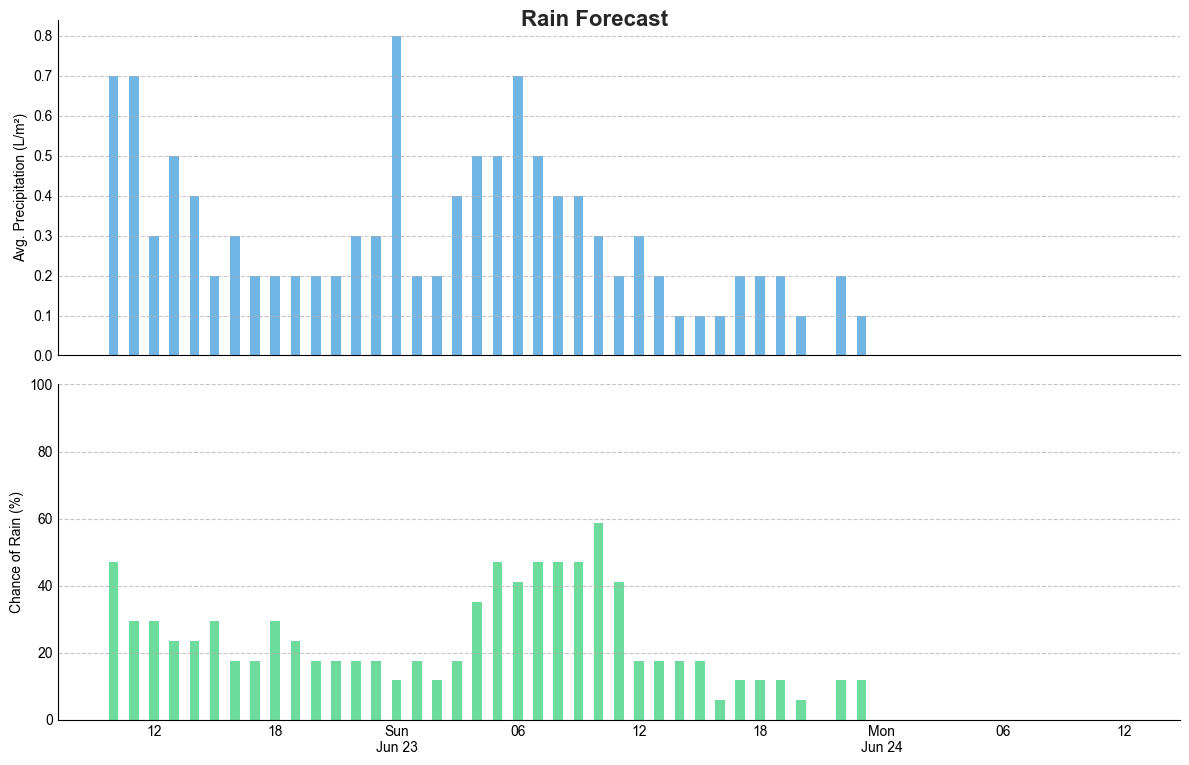

In [36]:
plot_rain_chance(chance_prec,avg_prec)

In [37]:
########################################################

día_año_hoy = (datetime.now()+timedelta(hours=2)).timetuple().tm_yday

día_año_mañana = día_año_hoy + 1 #(datetime.now()+timedelta(hours=0)).timetuple().tm_yday

hora_día = (datetime.now()+timedelta(hours=2)).hour



# Definir el array de valores
arr_max = datos_df_global[datos_df_global["día_del_año"]==día_año_hoy]["tmax"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_max = temp_data[temp_data.index.day_of_year==día_año_hoy].mean(axis=1).max().round(1)


# Definir el array de valores
arr_min = datos_df_global[datos_df_global["día_del_año"]==día_año_hoy]["tmin"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_min = temp_data[temp_data.index.day_of_year==día_año_hoy].mean(axis=1).min().round(1)

# Calcular el percentil

percentil_max_hoy = percentileofscore(arr_max, valor_max)

percentil_min_hoy = percentileofscore(arr_min, valor_min)



# Definir el array de valores
arr_max = datos_df_global[datos_df_global["día_del_año"]==día_año_mañana]["tmax"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_max_mañana = temp_data[temp_data.index.day_of_year==día_año_mañana].mean(axis=1).max().round(1)


# Definir el array de valores
arr_min = datos_df_global[datos_df_global["día_del_año"]==día_año_mañana]["tmin"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_min_mañana = temp_data[temp_data.index.day_of_year==día_año_mañana].mean(axis=1).min().round(1)

# Calcular el percentil

percentil_max_mañana = percentileofscore(arr_max, valor_max_mañana)

percentil_min_mañana = percentileofscore(arr_min, valor_min_mañana)


AttributeError: module 'datetime' has no attribute 'now'

In [38]:
texto_percentil = "El percentil indica cómo es la temperatura frente a los registros históricos, un valor cercano a 100 indica un registro extremadamente alto, uno cercano a 0 indica un registro extremadamente bajo."


if hora_día < 9:

    col1,col2,col3,col4 = st.columns(4,gap="small")

    col1.metric(":thermometer: Mínima hoy (ºC)",valor_min,int(percentil_min_hoy.round(0)),delta_color="off",help=texto_percentil)
    col2.metric(":thermometer: Máxima hoy (ºC)",valor_max,int(percentil_max_hoy.round(0)),delta_color="off",help=texto_percentil)
    col3.metric(":thermometer: Mínima mañana (ºC)",valor_min_mañana,int(percentil_min_mañana.round(0)),delta_color="off",help=texto_percentil)
    col4.metric(":thermometer: Máxima mañana (ºC)",valor_max_mañana,int(percentil_max_mañana.round(0)),delta_color="off",help=texto_percentil)


else:
    col1,col2,col3 = st.columns(3,gap="small")
    
    col1.metric(":thermometer: Máxima hoy (ºC)",valor_max,int(percentil_max_hoy.round(0)),delta_color="off",help=texto_percentil)
    col2.metric(":thermometer: Mínima mañana (ºC)",valor_min_mañana,int(percentil_min_mañana.round(0)),delta_color="off",help=texto_percentil)
    col3.metric(":thermometer: Máxima mañana (ºC)",valor_max_mañana,int(percentil_max_mañana.round(0)),delta_color="off",help=texto_percentil)


NameError: name 'hora_día' is not defined